# ENSF 612 Project Satellite Imagery Analysis

# Conner, Toshi, Brian, Mo 

In [151]:
# Import required libaries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import wget 
import os 
import pandas as pd 
from dotenv import load_dotenv
load_dotenv() # Reads the .env file in the current directory
import os
from PIL import Image
import fsspec
import json


HARD_DATA = True

manual_df = pd.DataFrame()
manual_df['year'] = range(2001,2025)
manual_df['Area Estimate'] = [585,591,621,623,659,682,675,702,712,744,752,742,744,771,779,768,802,786,797,804,836,830,864,854]

# Data Extraction, Grabbing the cloud_fraction dataset

In [152]:
if HARD_DATA:
    ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
    ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
    storage_options = {
        "account_name": ACCOUNT_NAME,
        "account_key": ACCOUNT_KEY,
    }
    gold_prefix = "abfs://gold@ucalgarydatalake01.dfs.core.windows.net/calgary_cloud_quality_classification_2000_2025.parquet"

    imagery_df = pd.read_parquet(
        gold_prefix,
        storage_options=storage_options,
        engine="fastparquet",
    )

    imagery_df['month'] = imagery_df['date'].dt.month.astype(int)
    imagery_df['date'] = imagery_df['date'].astype(str)
    print(imagery_df.head())


   year        date                                          rel_path  \
0  2002  2002-07-04  MCD06COSP_D3_MODIS.A2002185.062.2022125093622.nc   
1  2002  2002-07-05  MCD06COSP_D3_MODIS.A2002186.062.2022125090452.nc   
2  2002  2002-07-06  MCD06COSP_D3_MODIS.A2002187.062.2022125093033.nc   
3  2002  2002-07-07  MCD06COSP_D3_MODIS.A2002188.062.2022125085450.nc   
4  2002  2002-07-08  MCD06COSP_D3_MODIS.A2002189.062.2022125093738.nc   

                                          file_name  cloud_fraction  \
0  MCD06COSP_D3_MODIS.A2002185.062.2022125093622.nc        0.692232   
1  MCD06COSP_D3_MODIS.A2002186.062.2022125090452.nc        0.351298   
2  MCD06COSP_D3_MODIS.A2002187.062.2022125093033.nc        0.069563   
3  MCD06COSP_D3_MODIS.A2002188.062.2022125085450.nc        0.096447   
4  MCD06COSP_D3_MODIS.A2002189.062.2022125093738.nc        0.999263   

   quality_class  month  
0              3      7  
1              2      7  
2              0      7  
3              0      7  
4   

# Data Filtering, Remove cloudy data and filter for July

In [153]:
# Only select images that do not have clouds and are in summer months, this will be more complicated if we don't manually label the cloudy data 
if HARD_DATA:
    cleaned_df = imagery_df.query("cloud_fraction < 0.1 & cloud_fraction > 0 & month == 7")
    cleaned_df['month'] = cleaned_df['month'].astype(int)

C:\Users\ctcas\AppData\Local\Temp\ipykernel_24824\1483800503.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['month'] = cleaned_df['month'].astype(int)


In [154]:
print(f'Total length of precleaned dataset: {len(imagery_df)}') 
print(f'Total length of cleaned dataset: {len(cleaned_df)}')

Total length of precleaned dataset: 2173
Total length of cleaned dataset: 79


In [155]:
def decode_fft_polar_uint8(encoded: dict) -> np.ndarray:
    """
    Invert the encode_fft_polar_uint8() representation back to a complex FFT array.
    """
    mag_q = encoded["mag_q"].astype(np.float32)
    phase_q = encoded["phase_q"].astype(np.float32)
    mag_max = float(encoded["mag_max"])
    shape = tuple(encoded["shape"].tolist())

    # Dequantize magnitude
    mag_norm = mag_q / 255.0
    mag_log = mag_norm * mag_max
    mag = np.expm1(mag_log)

    # Dequantize phase
    phase_norm = phase_q / 255.0
    phase = phase_norm * (2 * np.pi) - np.pi

    real = mag * np.cos(phase)
    imag = mag * np.sin(phase)
    fft_arr = (real + 1j * imag).astype(np.complex64)

    return fft_arr.reshape(shape)

def fft_rgb_to_image(fft_block: np.ndarray, width: int, height: int) -> Image.Image:
    fft_block = np.asarray(fft_block)
    if fft_block.ndim != 3 or fft_block.shape[2] != 3:
        raise ValueError(f"Expected fft_block of shape (K, K, 3), got {fft_block.shape}")

    K_h, K_w, C = fft_block.shape
    if K_h != K_w:
        raise ValueError(f"Expected square block, got {fft_block.shape}")
    if C != 3:
        raise ValueError("Expected 3 channels (RGB)")

    H, W = int(height), int(width)

    full_fft = np.zeros((H, W, 3), dtype=fft_block.dtype)

    cy, cx = H // 2, W // 2
    half = K_h // 2

    y0, y1 = cy - half, cy - half + K_h
    x0, x1 = cx - half, cx - half + K_h

    full_fft[y0:y1, x0:x1, :] = fft_block

    F_unshift = np.fft.ifftshift(full_fft, axes=(0, 1))
    img_complex = np.fft.ifft2(F_unshift, axes=(0, 1))  # (H, W, 3)
    img_real = np.real(img_complex)

    img_real = np.clip(img_real, 0, 255).astype(np.uint8)
    return Image.fromarray(img_real)

In [156]:
bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"
if HARD_DATA:
    for i in range(len(cleaned_df)):
        year = cleaned_df.iloc[i]['year']
        date = cleaned_df.iloc[i]['date']
        #path = bronze_prefix + f"/year={year}/worldview_fft_{date.strip()}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
        path = bronze_prefix + f"/year={year}/worldview_fft_{date}_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
        fs_,_,paths = fsspec.get_fs_token_paths(path, storage_options=storage_options)

        with fs_.open(paths[0], "rb") as f:
            data = np.load(f, allow_pickle=True)
            fft_arr = data["fft"]
            meta = json.loads(data["meta"].item())

        recon_img = fft_rgb_to_image(fft_arr,275,275) #how to get the image from an fft.
        numpy_image = np.array(recon_img)
        opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite('./city_images/cleaned/basic_good_image_set/'+date+'.jpg',opencv_image)


# Image Processing, Take clean data, apply bitmasks

In [157]:
# Improved image processing with boundaries to exclude surrounding towns
# Also tracks urban growth over time - city only grows, never shrinks

# Define outer boundary to exclude Airdrie, Okotoks, etc
outer_boundary = [
    [0.14, 0.30],  [0.25, 0.28],  [0.40, 0.23],  [0.60, 0.22],  [0.75, 0.23],
    [0.77, 0.38],  [0.92, 0.40],  [0.92, 0.60],  [0.88, 0.80],  [0.70, 0.87],
    [0.50, 0.90],  [0.30, 0.85],  [0.25, 0.70],  [0.10, 0.60],  [0.06, 0.40]
]

# Inner boundary is the city center from 2001 (always urban)
inner_boundary = [
    [0.14, 0.39],  [0.25, 0.39],  [0.40, 0.37],  [0.50, 0.37],  [0.58, 0.45],
    [0.65, 0.39],  [0.65, 0.41],  [0.65, 0.60],  [0.60, 0.80],  [0.55, 0.83],
    [0.50, 0.82],  [0.41, 0.79],  [0.31, 0.62],  [0.24, 0.60],  [0.14, 0.40]
]

print(f"Processing {len(cleaned_df)} images...")

# Need to sort by year first
df_sorted = cleaned_df.sort_values('year')

# This stores what was urban in previous years
prev_urban = None
images_processed = []

for idx, row in df_sorted.iterrows():
    im_fn = row['date']
    year = row['year']
    
    # Load the image
    img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + im_fn+'.jpg')
    h, w = img.shape[:2]
    
    # Make outer boundary mask
    outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
    outer = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(outer, [outer_pts], 255)
    
    # Make inner boundary mask
    inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
    inner = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(inner, [inner_pts], 255)
    
    # Area between inner and outer boundaries
    between = cv2.subtract(outer, inner)
    
    red_channel = img[:, :, 2]

    ret, red_bitmask = cv2.threshold(red_channel, 75, 150, cv2.THRESH_BINARY) 
    ret, not_green = cv2.threshold(red_bitmask, 0, 255, cv2.THRESH_BINARY)

    between_urban = cv2.bitwise_and(between, not_green)
    
    # Combine inner + between urban areas
    this_year = cv2.bitwise_or(inner, between_urban)

    result = this_year
    
    prev_urban = result.copy()
    
    # Save result
    cv2.imwrite('./city_images/processed/basic_good_image_set/' + im_fn.split('.')[0] + '.bmp', result)
    images_processed.append(result)
    
    pixels = cv2.countNonZero(result)
    print(f"{year}: {pixels:,} pixels")

print(f"\nDone! Processed {len(images_processed)} images") 

Processing 79 images...
2002: 15,637 pixels
2002: 21,528 pixels
2002: 17,006 pixels
2002: 19,780 pixels
2002: 15,887 pixels
2003: 16,479 pixels
2003: 14,421 pixels
2003: 14,210 pixels
2003: 18,799 pixels
2003: 15,726 pixels
2003: 15,860 pixels
2003: 20,764 pixels
2004: 16,231 pixels
2004: 16,736 pixels
2006: 17,542 pixels
2006: 16,605 pixels
2007: 15,719 pixels
2007: 18,059 pixels
2007: 16,861 pixels
2007: 18,217 pixels
2007: 23,751 pixels
2007: 16,361 pixels
2008: 15,503 pixels
2008: 18,680 pixels
2009: 20,653 pixels
2010: 14,571 pixels
2010: 18,290 pixels
2011: 19,219 pixels
2011: 16,545 pixels
2011: 18,279 pixels
2012: 18,811 pixels
2012: 19,702 pixels
2013: 20,348 pixels
2013: 17,402 pixels
2013: 15,392 pixels
2014: 19,225 pixels
2014: 19,226 pixels
2014: 16,310 pixels
2014: 19,793 pixels
2014: 19,227 pixels
2014: 20,442 pixels
2015: 22,739 pixels
2015: 18,833 pixels
2015: 17,760 pixels
2017: 21,516 pixels
2017: 17,778 pixels
2017: 22,615 pixels
2017: 19,937 pixels
2017: 20,336 pix

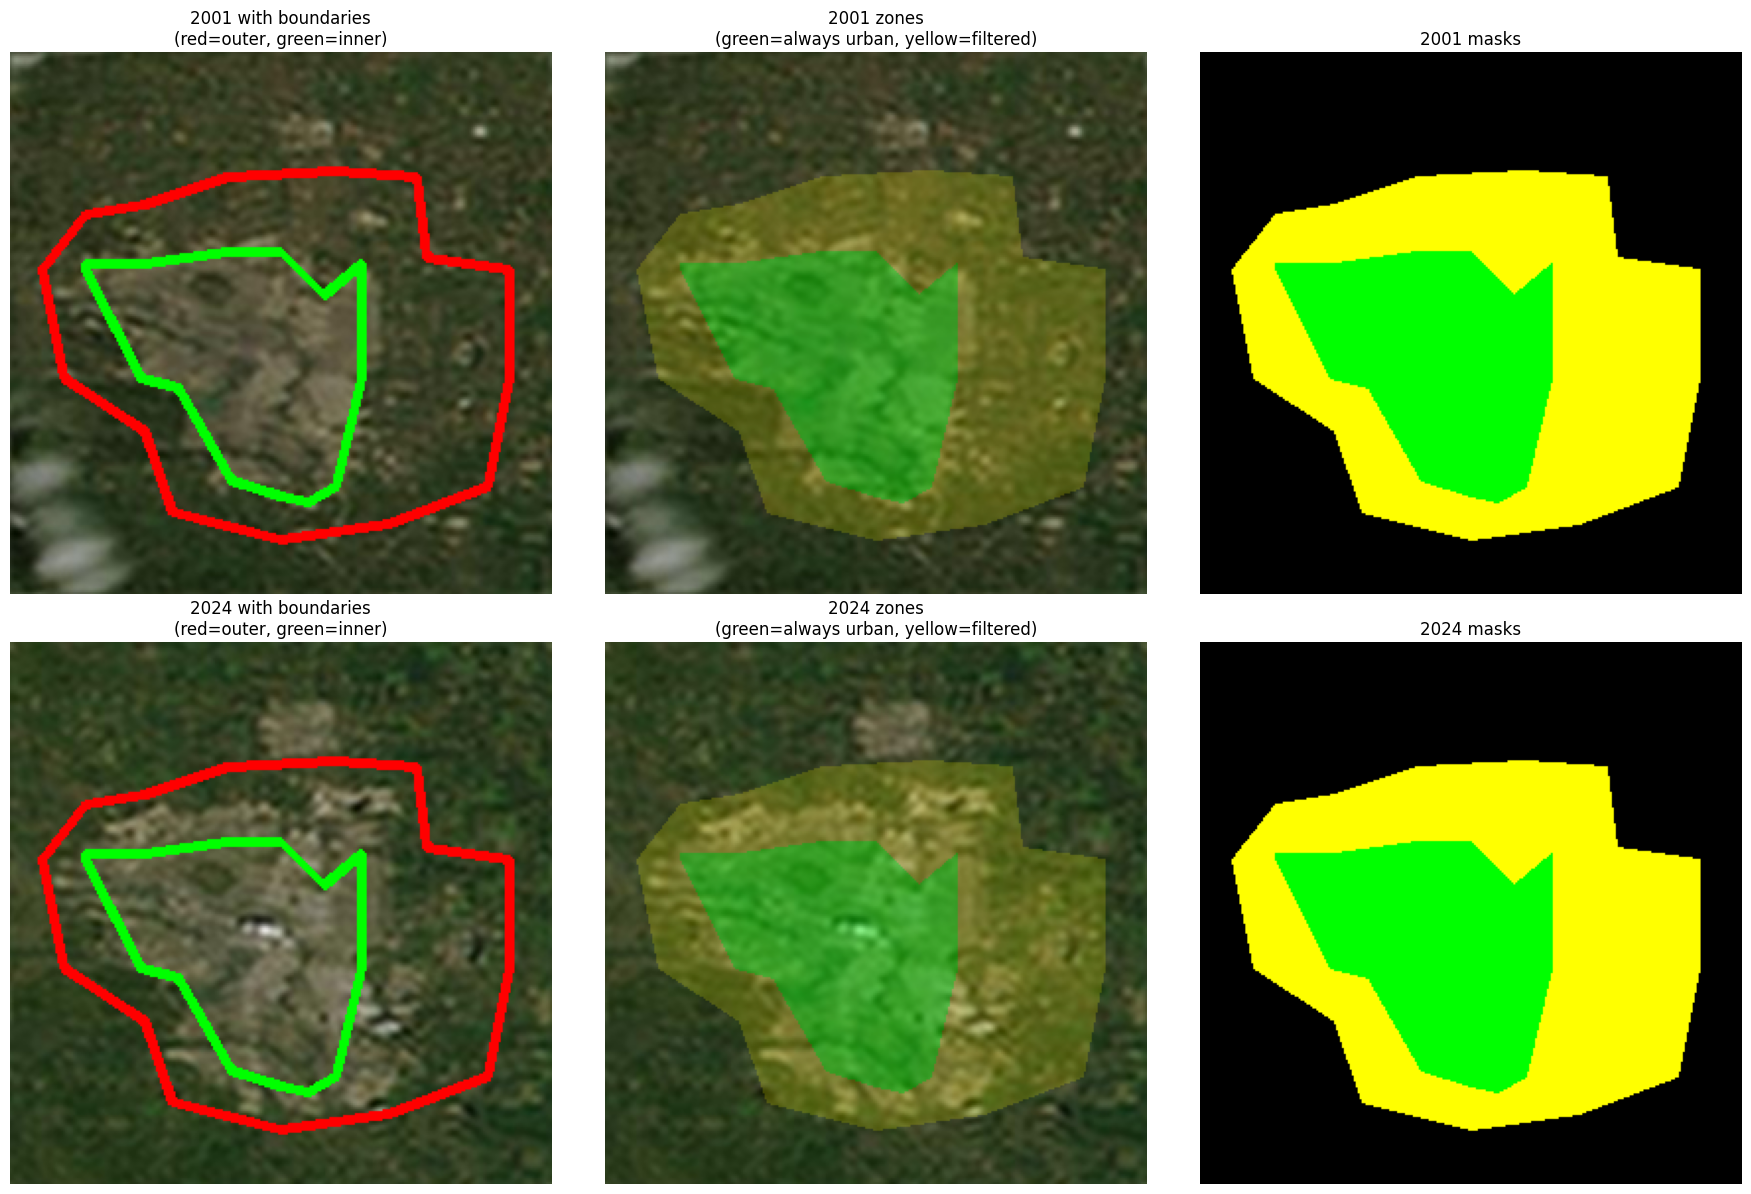

In [158]:
# Optional: Check boundaries on 2001 and 2024 images

# Get 2001 and 2024 images
year_2001 = cleaned_df[cleaned_df['year'] == 2002].iloc[0]
year_2024 = cleaned_df[cleaned_df['year'] == 2024].iloc[0]

test_years = [(2001, year_2001), (2024, year_2024)]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (year, row) in enumerate(test_years):
    # Load image
    img = cv2.imread('./city_images/cleaned/basic_good_image_set/' + row['date']+'.jpg')
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Make boundaries
    outer_pts = np.array([[int(w*x), int(h*y)] for x, y in outer_boundary], dtype=np.int32)
    inner_pts = np.array([[int(w*x), int(h*y)] for x, y in inner_boundary], dtype=np.int32)
    
    outer = np.zeros((h, w), dtype=np.uint8)
    inner = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(outer, [outer_pts], 255)
    cv2.fillPoly(inner, [inner_pts], 255)
    
    # Image with boundary lines
    img_lines = img_rgb.copy()
    cv2.polylines(img_lines, [outer_pts], True, (255, 0, 0), 3)
    cv2.polylines(img_lines, [inner_pts], True, (0, 255, 0), 3)
    axes[idx][0].imshow(img_lines)
    axes[idx][0].set_title(f'{year} with boundaries\n(red=outer, green=inner)')
    axes[idx][0].axis('off')
    
    # Colored overlay
    overlay = img_rgb.copy()
    overlay[inner == 255] = overlay[inner == 255] * 0.6 + np.array([0, 255, 0]) * 0.4
    between = cv2.subtract(outer, inner)
    overlay[between == 255] = overlay[between == 255] * 0.8 + np.array([255, 255, 0]) * 0.2
    axes[idx][1].imshow(overlay)
    axes[idx][1].set_title(f'{year} zones\n(green=always urban, yellow=filtered)')
    axes[idx][1].axis('off')
    
    # Just masks
    masks = np.zeros((h, w, 3), dtype=np.uint8)
    masks[inner == 255] = [0, 255, 0]
    masks[between == 255] = [255, 255, 0]
    axes[idx][2].imshow(masks)
    axes[idx][2].set_title(f'{year} masks')
    axes[idx][2].axis('off')

plt.tight_layout()
plt.show()

# Image Analysis, Make area calculations

In [159]:
# Determine distances of image manually 
distance_width = 42 # km - determined from calculator: https://www.nhc.noaa.gov/gccalc.shtml
distance_height = 67 # km - determined from calculator: " 

area_per_year = pd.DataFrame()

for i in range(len(cleaned_df)):
    # im_fm = cleaned_df.iloc[i]['date']
    # print()
    image = cv2.imread('./city_images/processed/basic_good_image_set/'+cleaned_df.iloc[i]['date']+'.bmp',cv2.IMREAD_GRAYSCALE)

    # Calculate sq km per pixel 
    pixel_width = 275 
    pixel_height = 275
    sqkmpp = (distance_width*distance_height)/(pixel_height*pixel_width)
    
    # Calculate area estimate 
    area_estimate = cv2.countNonZero(image)*sqkmpp
    # print(area_estimate)
    # area_per_year.append(area_estimate)
    area_per_year.at[i,'year'] = cleaned_df.iloc[i]['year']
    area_per_year.at[i,'area_estimate'] = area_estimate

# Area estimates 
print(area_per_year.head())


     year  area_estimate
0  2002.0     581.851478
1  2002.0     801.055101
2  2002.0     632.791855
3  2002.0     736.012165
4  2002.0     591.153957


In [160]:
# Aggregate by year 
average_by_year = area_per_year.groupby(area_per_year['year'])['area_estimate'].mean()
print(average_by_year.head())

year
2002.0    668.572911
2003.0    617.998255
2004.0    613.349673
2006.0    635.303524
2007.0    675.781712
Name: area_estimate, dtype: float64


# Graph Visualization

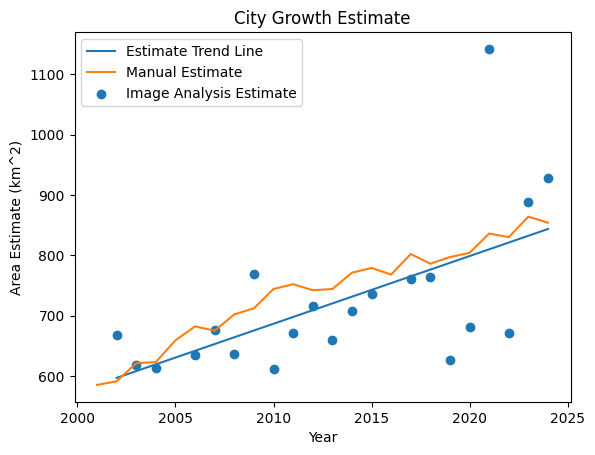

In [161]:
years_manual = list(manual_df['year'])
manual_area = list(manual_df['Area Estimate'])
years_auto = average_by_year.index.tolist()
years_auto = [int(x) for x in years_auto]
m, b = np.polyfit(years_auto, average_by_year.tolist(), 1)

# Create the regression line equation
y_pred = m * np.array(years_auto) + b
plt.plot(years_auto,y_pred,label='Estimate Trend Line')
plt.plot(years_manual,manual_area,label='Manual Estimate')
plt.scatter(average_by_year.index.tolist(),average_by_year.tolist(),label='Image Analysis Estimate')
plt.xlabel('Year')
plt.ylabel('Area Estimate (km^2)')
plt.title('City Growth Estimate')
plt.legend()

Average Error: 14.30%


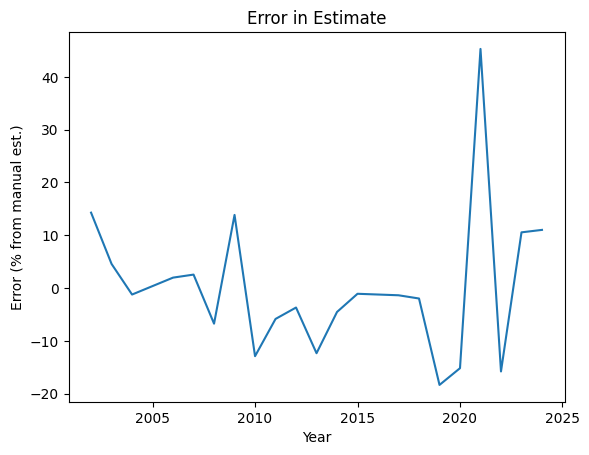

In [162]:
per_error = [] 
for i in range(len(average_by_year)):
    error = (average_by_year.iat[i] - manual_area[i])/manual_area[i]*100
    per_error.append(error)

plt.plot(years_auto,per_error)
plt.xlabel('Year')
plt.ylabel('Error (% from manual est.)')
plt.title('Error in Estimate')
print(f"Average Error: {sum(per_error)/len(per_error)*100:.2f}%")